# Detecting outliers using residuals and LOWESS

In this notebook we show how to identify outliers in time series using LOWESS. However, this time we shall analyse the residuals to determine if a given data point is an outlier.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# The 1.5 x IQR rule

A common rule to determine whether a particular data point is an outlier is the 1.5 x interquartile range (IQR) rule.

This rule states that a data point $x$ is an outlier if:

$$x > Q_3 + 1.5 \times IQR$$
$$x <Q_1 - 1.5 \times IQR$$

where $Q1$ and $Q3$ are the 1st and 3rd quartiles respectively.

Why 1.5? Assuming that $x$ is normally distributed it can be shown that the above thresholds correspond to 2.7$\sigma$ from the mean, where $\sigma$ is the standard deviation. This is close to 3$\sigma$. If $x$ is normally distributed then 99.7% of the observations will lie within 3$\sigma$ of the mean. Data that is outside 3$\sigma$ is unlikely and hence could be flagged as an outlier.

A different factor from 1.5 can be used to adjust the sensitivity of outlier detection (i.e., a smaller value will be more sensitive, a larger value will be less sensitive). If the data is not normally distributed then another factor may be preferred. 

So far all of this assumes that the distribution of $x$ does not change over time. How can we apply this to time series? We can examine the residuals. The residuals are computed: $e_t = y_t - \hat{y}_t$ where $\hat{y}_t$ is obtained by an estimation method, such as the rolling median.  If we observe that the residuals are stationary (i.e., the mean and standard deviation of the residuals do not change with time) then we can compute the quartiles and interquartile range of the residuals and use the 1.5 x IQR rule above. A good estimation method would typically result in stationary residuals.

A plot of the residuals over time can visually inspected as a sense check to ensure they are stationary.

# Load data

In [2]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot the data to visually inspect any outliers

Text(0.5, 0, 'Time')

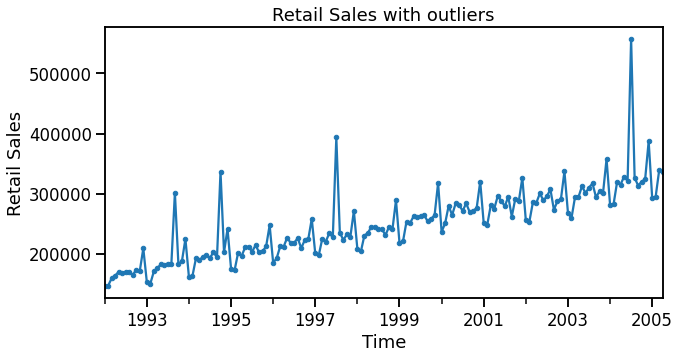

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

The seasonal spikes in the data are likely to be picked up as outliers. We shall de-seasonalise the data first using STL decomposition as shown in the previous notebook. 

# De-seasonalise data

A large value for the `seasonal` parameter is chosen for the STL decomposition, this is based on an assumption that the seasonality is not changing very much. In addition we set the `robust` parameter to True which implements an outlier robust version of STL decomposition.

In [4]:
# Apply STL decomposition
res = STL(df["y"], robust=True).fit()
seasonal_component = res.seasonal
seasonal_component.head()

ds
1992-01-01   -18117.495889
1992-02-01   -19115.124261
1992-03-01    -5472.704639
1992-04-01     -934.499381
1992-05-01     2910.868481
Name: season, dtype: float64

In [5]:
df_deseasoned = (df["y"] - seasonal_component).to_frame("y")

In [6]:
df_deseasoned.head()

,y
ds,
1992-01-01,164493.495889
1992-02-01,166194.124261
1992-03-01,164808.704639
1992-04-01,164603.499381
1992-05-01,167157.131519


Text(0.5, 0, 'Time')

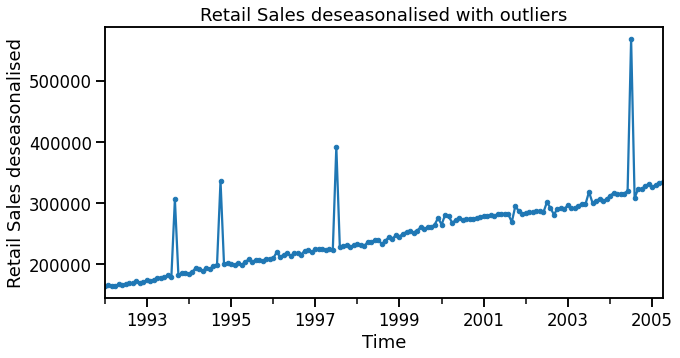

In [7]:
fig, ax = plt.subplots(figsize=[10, 5])

df_deseasoned.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

# Fit a trend line using LOWESS and examine residuals

Any estimation method could be used to provide an expected value $\hat{y}_t$ from which we can go on to examine the residuals. We could use the rolling mean or median introduced in the previous notebook. Instead, we shall introduce the idea of using LOWESS to provide an expected value $\hat{y}_t$. LOWESS has the advantages of being robout to outliers and not having the same issues with smaller windows at the edge of the time series that rolling averages have.

The expected value $\hat{y}_t$ is computed as the trend obtained from LOWESS:

$$\hat{y}_t = trend_t$$

where the $trend_t$ is the value of the trend obtained by LOWESS at time $t$.

The residuals are computed: $e_t = y_t - \hat{y}_t$
and the quartiles and interquartile range of the residuals are calculated across the whole time series.

The threshold is defined by the distance from the lower and upper quartiles of the residuals and does not depend on time:

$$\delta_{upper} = Q_3 + \alpha \times IQR$$
$$\delta_{lower} = Q_1 - \alpha \times IQR$$

As mentioned above $\alpha=1.5$ is a typical choice, however this can be adjusted depending on how sensitive you want the outlier detection to be.

A data point is an outlier if:
$$e_t = y_t - \hat{y}_t > \delta_{upper}$$
$$e_t = y_t - \hat{y}_t < \delta_{lower}$$


In [8]:
df_ = df_deseasoned.copy()

The expected value $\hat{y}_t$ is computed as the trend obtained from LOWESS:

$$\hat{y}_t = trend_t$$

where the $trend_t$ is the value of the trend obtained by LOWESS at time $t$.

Text(0.5, 0, 'Time')

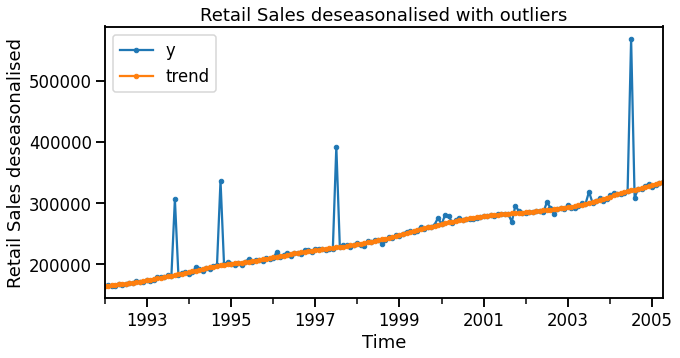

In [9]:
y = df_["y"].values
# The x-values must be numbers rather than dates to fit the LOWESS model.
x = np.arange(0, len(y), 1)
trend = lowess(y, x, frac=0.1)
df_["trend"] = trend[:, 1]

ax = df_.plot(y=["y", "trend"], marker=".", figsize=[10, 5])
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

In [10]:
# Compute residuals
df_["residual"] = df_["y"] - df_["trend"]

# Compute inter-quartile range
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply 1.5 IQR as a threshold to identify outliers
factor = 1.5
df_["lower"] = Q1 - factor * IQR
df_["upper"] = Q3 + factor * IQR
df_["is_outlier"] = (df_["residual"] < (Q1 - factor * IQR)) | (
    df_["residual"] > (Q3 + factor * IQR)
)

df_.head()

,y,trend,residual,lower,upper,is_outlier
ds,,,,,,
1992-01-01,164493.495889,164121.229515,372.266374,-5613.803645,5794.196624,False
1992-02-01,166194.124261,164746.509329,1447.614932,-5613.803645,5794.196624,False
1992-03-01,164808.704639,165382.782243,-574.077604,-5613.803645,5794.196624,False
1992-04-01,164603.499381,166026.292837,-1422.793457,-5613.803645,5794.196624,False
1992-05-01,167157.131519,166672.981269,484.150250,-5613.803645,5794.196624,False


Let's plot the results

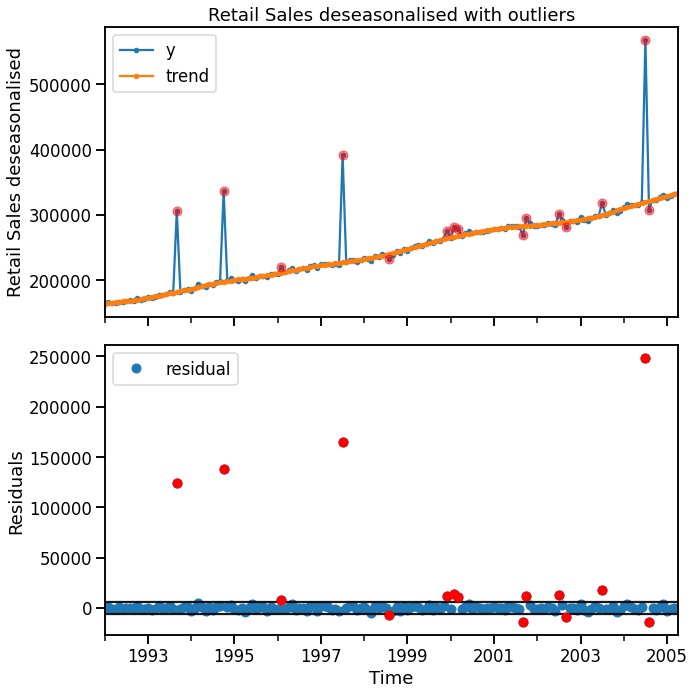

In [11]:
# Plot time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df_.plot(y=["y", "trend"], marker=".", ax=ax[0])
df_["residual"] = df_["residual"]

# Plot residuals
df_.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.9)

# If any data points are identified as an outlier, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
    )
    df_["residual"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[1], legend=None, linestyle=""
    )

ax[0].set_title("Retail Sales deseasonalised with outliers")
ax[0].set_ylabel("Retail Sales deseasonalised")
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("Time")
plt.tight_layout()

We can also visualise the residuals for outliers using a histogram and box plot. This also allows us to check that the data is approximately normal.

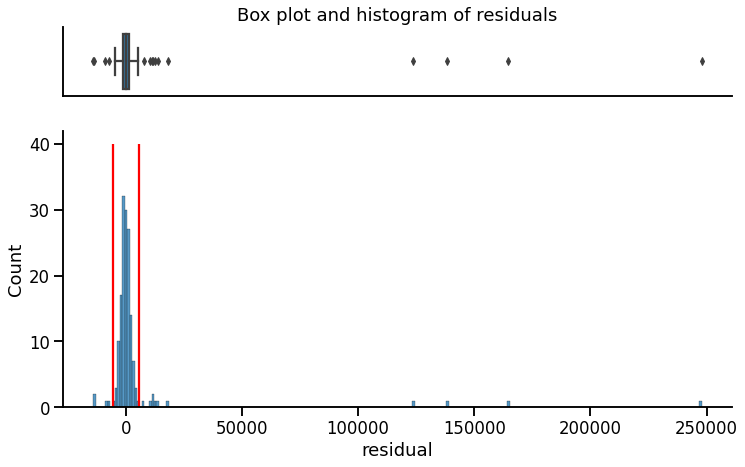

In [12]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=[12, 7]
)
sns.boxplot(x=df_["residual"], ax=ax_box)
sns.histplot(x=df_["residual"], ax=ax_hist)

ax_box.axes.get_xaxis().set_visible(False)
ax_box.axes.get_yaxis().set_visible(False)
ax_box.set_title('Box plot and histogram of residuals')
    
ax_hist.vlines(Q1 - factor * IQR, 0, 40, color="r")
ax_hist.vlines(Q3 + factor * IQR, 0, 40, color="r")
sns.despine()
plt.show()

As we can see the residual method is much more sensitive and identified even smaller flucatuations in the data. The outliers are much clearer in the residual plot. To make the methods less sensitive, a simple solution would be to adjust threshold.